In [27]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/mika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
data = pd.read_csv('../data/processed/sarcasm_headlines_processed.csv')

In [16]:
#clean data
X_clean = data['headline'].replace('[^ -~]+', '', regex=True)
X_clean = X_clean.str.replace('[^\w\s]','', regex=True)
X_clean = X_clean.replace('_', '', regex=True)
X_clean = X_clean.replace('\d+', '', regex=True) 

In [17]:
#lemmatizer
lemmatizer = WordNetLemmatizer()
X_clean = X_clean.apply(lambda X: ' '.join([lemmatizer.lemmatize(i) for i in X.split()]))

In [18]:
X_clean

0        thirtysomething scientist unveil doomsday cloc...
1        dem rep totally nail why congress is falling s...
2             eat your veggie deliciously different recipe
3        inclement weather prevents liar from getting t...
4        mother come pretty close to using word streami...
                               ...                        
55323                  american politics in moral freefall
55324                                    america best hike
55325                                 reparation and obama
55326    israeli ban targeting boycott supporter raise ...
55327                          gourmet gift for the foodie
Name: headline, Length: 55328, dtype: object

In [19]:
#stopwords
stop = stopwords.words('english')
X_clean_fin = X_clean.apply(lambda x: ' '.join([w for w in x.split() if w not in (stop)]))

In [20]:
X_clean_fin

0        thirtysomething scientist unveil doomsday cloc...
1        dem rep totally nail congress falling short ge...
2                  eat veggie deliciously different recipe
3             inclement weather prevents liar getting work
4        mother come pretty close using word streaming ...
                               ...                        
55323                     american politics moral freefall
55324                                    america best hike
55325                                     reparation obama
55326    israeli ban targeting boycott supporter raise ...
55327                                  gourmet gift foodie
Name: headline, Length: 55328, dtype: object

In [21]:
#data split
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_clean_fin, data['is_sarcastic'], test_size=0.4, random_state=4)

In [22]:
#tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_rnn)
X_train_rnn_tok = tokenizer.texts_to_sequences(X_train_rnn)
X_test_rnn_tok = tokenizer.texts_to_sequences(X_test_rnn)
vocab_len = len(tokenizer.word_index)

In [23]:
vocab_len

22844

In [24]:
word_len = max([len(i) for i in X_train_rnn])
word_len

226

In [28]:
#padding for RNN
X_train_rnn = pad_sequences(X_train_rnn_tok, maxlen = 30)
X_test_rnn = pad_sequences(X_test_rnn_tok, maxlen = 30)

In [29]:
X_train_rnn[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 4490, 6235,  333,
       1588,  555,  211,   14, 1491,  436,  116,   22], dtype=int32)

## Model testing

In [30]:
#basic model
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=200),
    layers.LSTM(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5352 - loss: 0.6889 - val_accuracy: 0.5914 - val_loss: 0.6750
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6441 - loss: 0.6593 - val_accuracy: 0.7242 - val_loss: 0.5759
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7538 - loss: 0.5286 - val_accuracy: 0.7904 - val_loss: 0.4725
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8461 - loss: 0.3762 - val_accuracy: 0.8290 - val_loss: 0.3971
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8899 - loss: 0.2804 - val_accuracy: 0.8310 - val_loss: 0.3982
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9106 - loss: 0.2351 - val_accuracy: 0.8362 - val_loss: 0.3916
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9265 - loss: 0.1944 - val_accuracy: 0.8320 - val_loss: 0.4388
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9436 - loss: 0.1624 - val_accuracy: 0.8458 - v

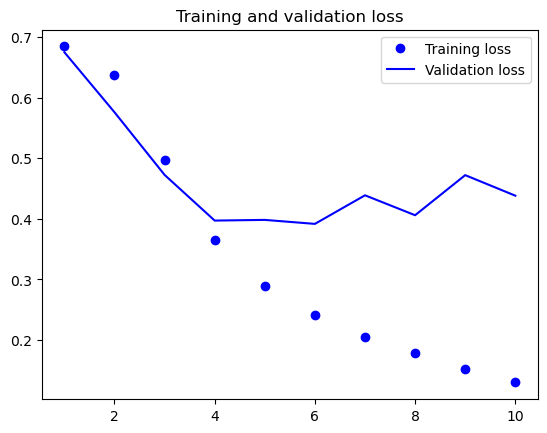

In [31]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


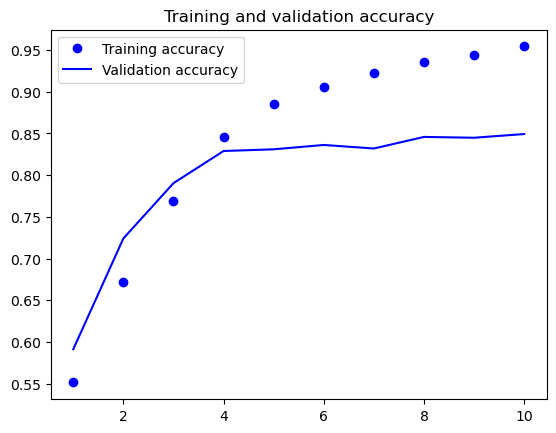

In [32]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()


In [33]:
#adding more neurons
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(100, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5384 - loss: 0.6881 - val_accuracy: 0.6158 - val_loss: 0.6739
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.6339 - loss: 0.6503 - val_accuracy: 0.7342 - val_loss: 0.5420
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7752 - loss: 0.4867 - val_accuracy: 0.8054 - val_loss: 0.4235
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8515 - loss: 0.3561 - val_accuracy: 0.8179 - val_loss: 0.4133
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8937 - loss: 0.2743 - val_accuracy: 0.8352 - val_loss: 0.3855
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9115 - loss: 0.2345 - val_accuracy: 0.8362 - val_loss: 0.3853
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9301 - loss: 0.1933 - val_accuracy: 0.8438 - val_loss: 0.4020
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9362 - loss: 0.1772 - val_accuracy: 0.845

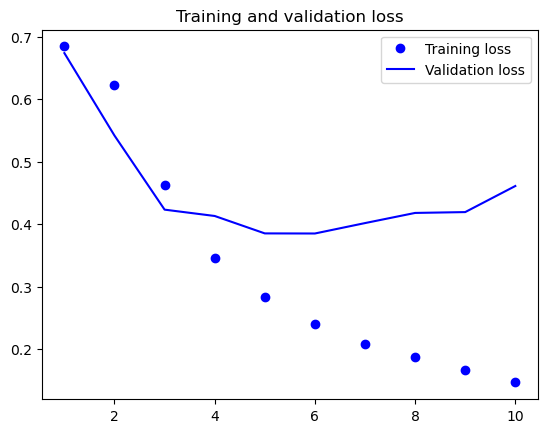

In [34]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

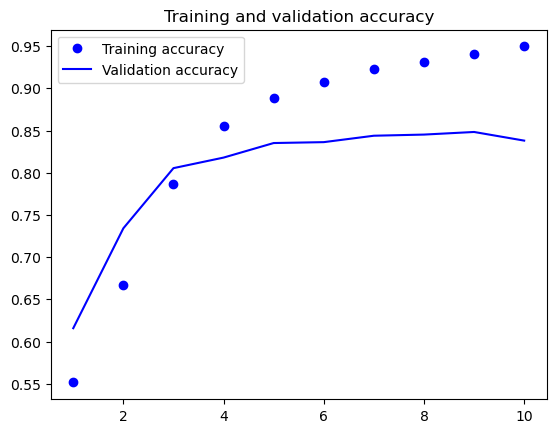

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [36]:
#dropout added
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(100, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5423 - loss: 0.6890 - val_accuracy: 0.5400 - val_loss: 0.6809
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5698 - loss: 0.6772 - val_accuracy: 0.6554 - val_loss: 0.6260
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.7078 - loss: 0.5919 - val_accuracy: 0.7865 - val_loss: 0.4840
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8161 - loss: 0.6388 - val_accuracy: 0.8077 - val_loss: 0.4230
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8539 - loss: 0.3672 - val_accuracy: 0.8147 - val_loss: 0.4239
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8881 - loss: 0.3031 - val_accuracy: 0.8275 - val_loss: 0.4141
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9103 - loss: 0.2572 - val_accuracy: 0.8368 - val_loss: 0.3834
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9263 - loss: 0.2234 - val_accuracy: 0.840

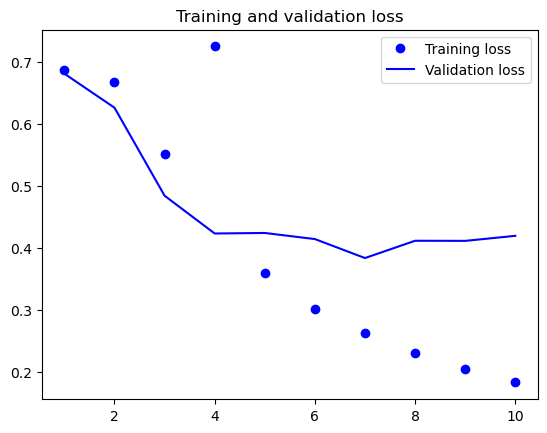

In [37]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


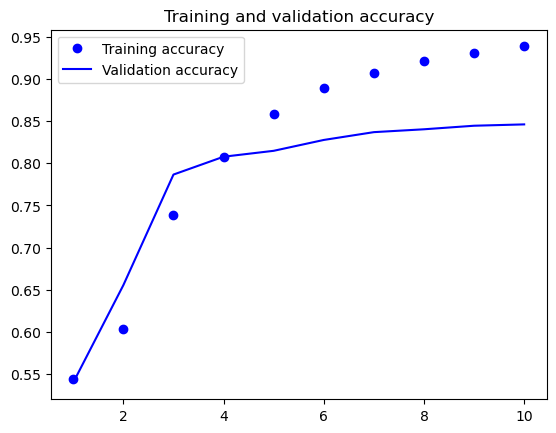

In [38]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [39]:
#dropout: 0.5
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(100, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5407 - loss: 0.6893 - val_accuracy: 0.5400 - val_loss: 0.6809
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5619 - loss: 0.6787 - val_accuracy: 0.6799 - val_loss: 0.6170
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7034 - loss: 0.5864 - val_accuracy: 0.7830 - val_loss: 0.4626
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8243 - loss: 33.4835 - val_accuracy: 0.8096 - val_loss: 0.4499
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8640 - loss: 0.3977 - val_accuracy: 0.8286 - val_loss: 0.3983
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8911 - loss: 0.3195 - val_accuracy: 0.8252 - val_loss: 0.4437
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9024 - loss: 0.2827 - val_accuracy: 0.8383 - val_loss: 0.4042
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9224 - loss: 0.2404 - val_accuracy: 0.84

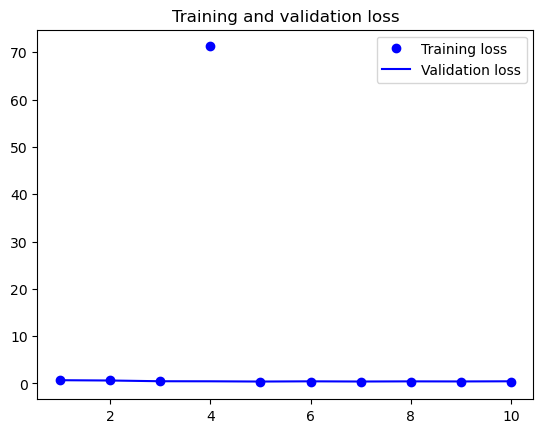

In [40]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

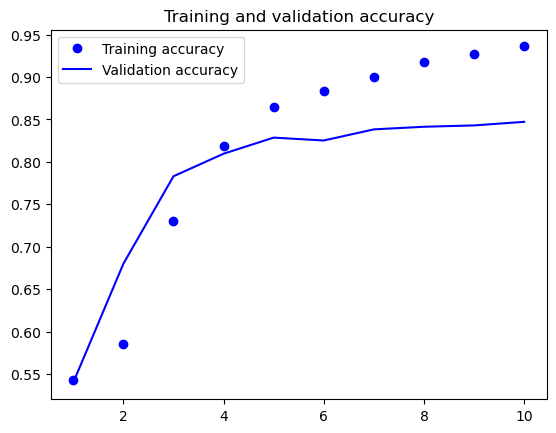

In [41]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [42]:
#dropout: mix
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5413 - loss: 0.6883 - val_accuracy: 0.5400 - val_loss: 0.6803
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5577 - loss: 0.6750 - val_accuracy: 0.6893 - val_loss: 0.6346
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7031 - loss: 0.5977 - val_accuracy: 0.7789 - val_loss: 0.4827
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8124 - loss: 0.4392 - val_accuracy: 0.8169 - val_loss: 0.4146
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8674 - loss: 0.3362 - val_accuracy: 0.8334 - val_loss: 0.3903
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8957 - loss: 0.2788 - val_accuracy: 0.8413 - val_loss: 0.3918
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9161 - loss: 0.2312 - val_accuracy: 0.8417 - val_loss: 0.3822
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9260 - loss: 0.2080 - val_accuracy: 0.8461 - v

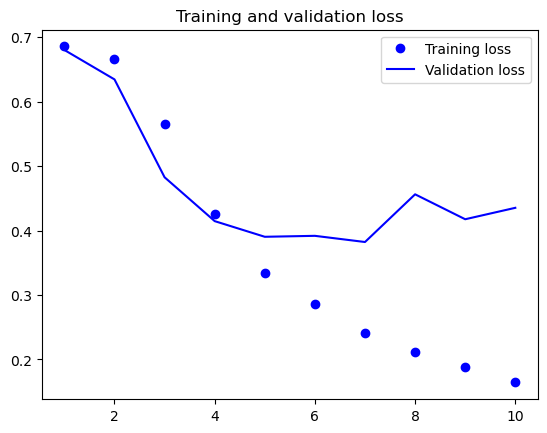

In [43]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

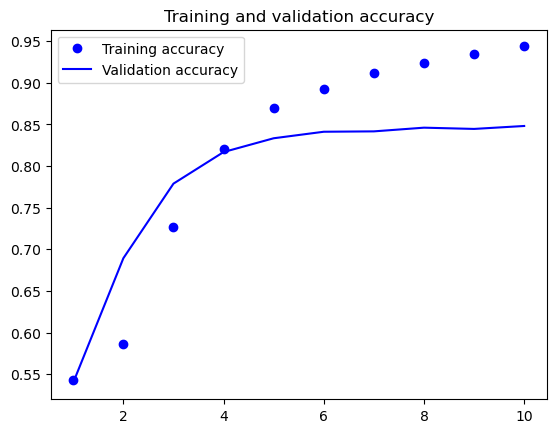

In [44]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [45]:
#dropout: mix + depth
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(8, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5405 - loss: 0.6888 - val_accuracy: 0.5400 - val_loss: 0.6776
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5611 - loss: 0.6691 - val_accuracy: 0.7061 - val_loss: 0.6141
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7407 - loss: 0.5863 - val_accuracy: 0.7931 - val_loss: 0.4874
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8403 - loss: 0.4404 - val_accuracy: 0.8230 - val_loss: 0.4133
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8802 - loss: 0.3398 - val_accuracy: 0.8316 - val_loss: 0.4023
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9058 - loss: 0.2704 - val_accuracy: 0.8363 - val_loss: 0.4008
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9184 - loss: 0.2341 - val_accuracy: 0.8421 - val_loss: 0.3992
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9314 - loss: 0.1993 - val_accuracy: 0.8424 - v

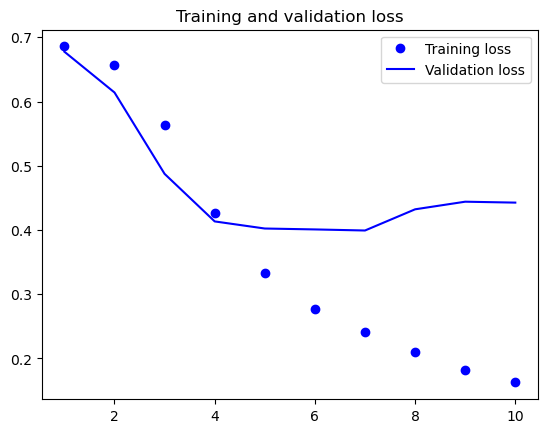

In [46]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

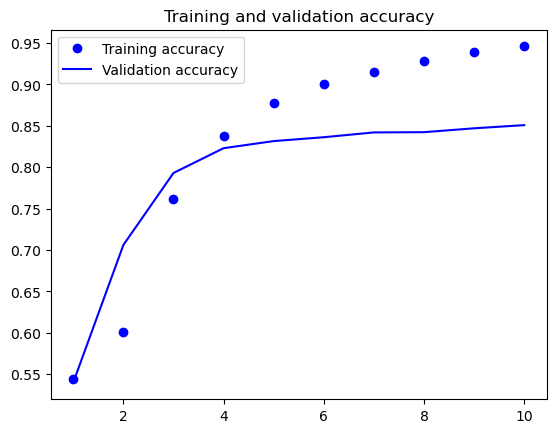

In [47]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [48]:
#change optimizer to Adam
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5529 - loss: 0.6769 - val_accuracy: 0.7916 - val_loss: 0.5474
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8097 - loss: 0.4897 - val_accuracy: 0.8275 - val_loss: 0.4008
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8883 - loss: 0.2857 - val_accuracy: 0.8366 - val_loss: 0.3829
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9228 - loss: 0.2054 - val_accuracy: 0.8443 - val_loss: 0.4134
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9410 - loss: 0.1561 - val_accuracy: 0.8455 - val_loss: 0.4643
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9564 - loss: 0.1207 - val_accuracy: 0.8483 - val_loss: 0.5208
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9644 - loss: 0.0980 - val_accuracy: 0.8503 - val_loss: 0.6199
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9758 - loss: 0.0729 - val_accuracy: 0.8502 - v

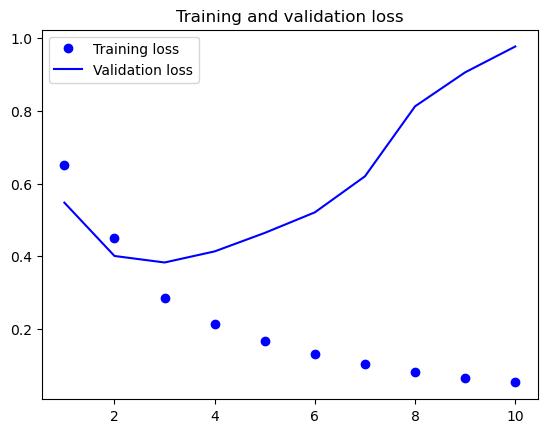

In [49]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

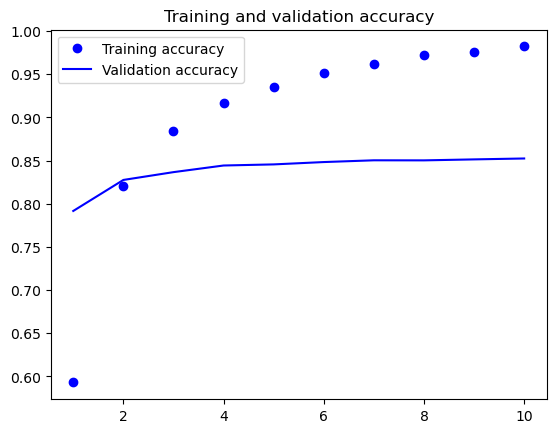

In [50]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [51]:
#optimizer: Adam + more neurons
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(50, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5575 - loss: 0.6782 - val_accuracy: 0.7903 - val_loss: 0.4843
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8478 - loss: 0.3928 - val_accuracy: 0.8345 - val_loss: 0.3751
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9147 - loss: 0.2326 - val_accuracy: 0.8443 - val_loss: 0.3695
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9375 - loss: 0.1749 - val_accuracy: 0.8504 - val_loss: 0.4270
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9550 - loss: 0.1287 - val_accuracy: 0.8527 - val_loss: 0.4549
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9676 - loss: 0.0977 - val_accuracy: 0.8544 - val_loss: 0.5820
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9767 - loss: 0.0691 - val_accuracy: 0.8576 - val_loss: 0.6843
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9819 - loss: 0.0542 - val_accuracy: 0.8580 - v

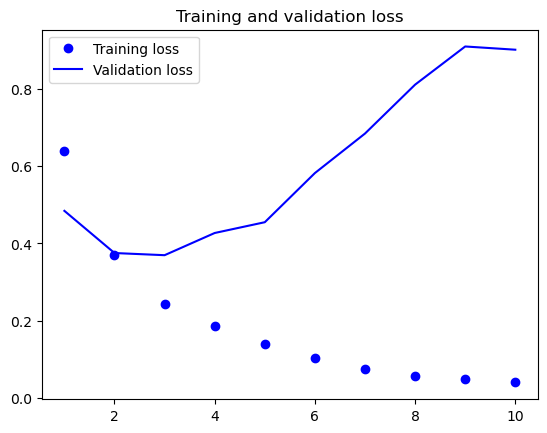

In [52]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

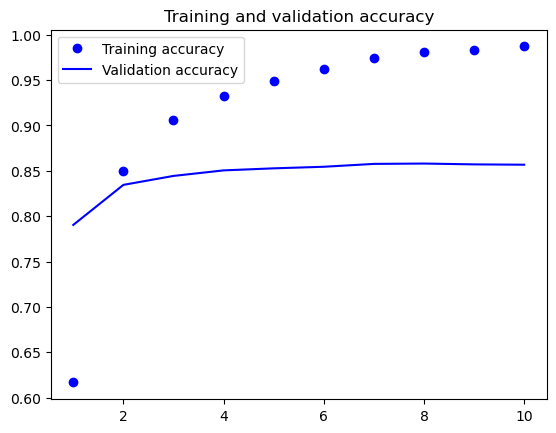

In [53]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [54]:
#optimizer: Adam + more neurons + bigger dropout rate
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(50, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5547 - loss: 0.6809 - val_accuracy: 0.7781 - val_loss: 0.5200
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8072 - loss: 0.4650 - val_accuracy: 0.8294 - val_loss: 0.3956
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8914 - loss: 0.2801 - val_accuracy: 0.8430 - val_loss: 0.4030
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9283 - loss: 0.1956 - val_accuracy: 0.8470 - val_loss: 0.4399
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9475 - loss: 0.1519 - val_accuracy: 0.8497 - val_loss: 0.5439
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9597 - loss: 0.1149 - val_accuracy: 0.8480 - val_loss: 0.7928
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9663 - loss: 0.0952 - val_accuracy: 0.8525 - val_loss: 0.8376
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9748 - loss: 0.0737 - val_accuracy: 0.8510 - 

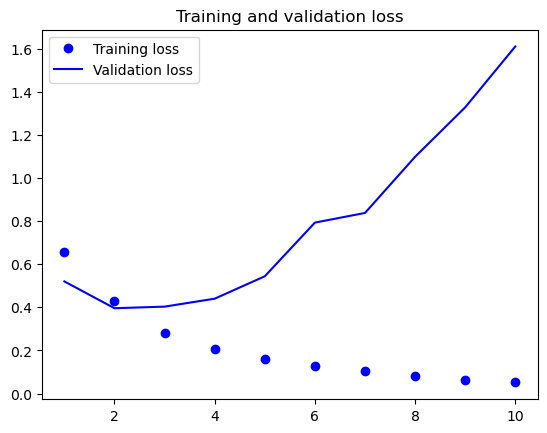

In [55]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

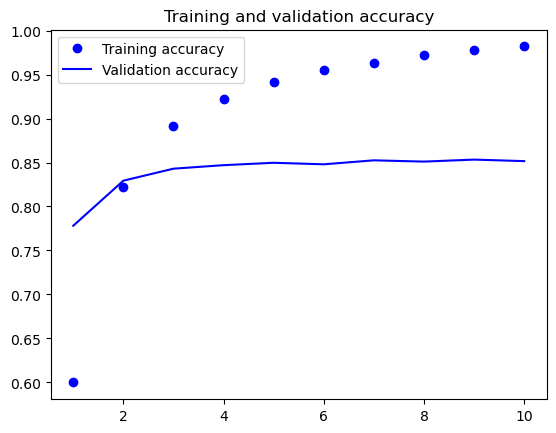

In [56]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [57]:
#optimizer: Adam without dropout
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5606 - loss: 0.6749 - val_accuracy: 0.6985 - val_loss: 0.6205
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7521 - loss: 0.5416 - val_accuracy: 0.8071 - val_loss: 0.4320
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8769 - loss: 0.3040 - val_accuracy: 0.8385 - val_loss: 0.3862
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9193 - loss: 0.2035 - val_accuracy: 0.8464 - val_loss: 0.4302
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9460 - loss: 0.1445 - val_accuracy: 0.8406 - val_loss: 0.4451
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9631 - loss: 0.1079 - val_accuracy: 0.8532 - val_loss: 0.5435
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9736 - loss: 0.0764 - val_accuracy: 0.8525 - val_loss: 0.6771
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9857 - loss: 0.0476 - val_accuracy: 0.8547 - v

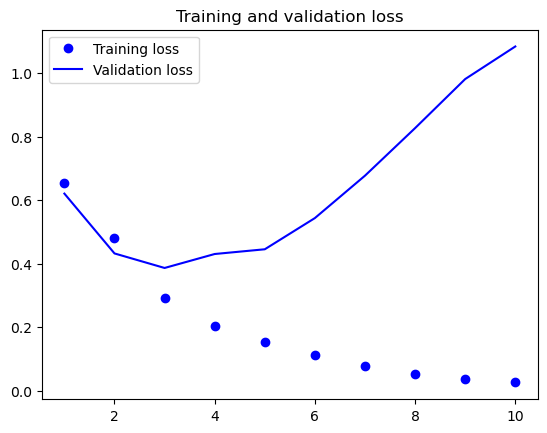

In [58]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

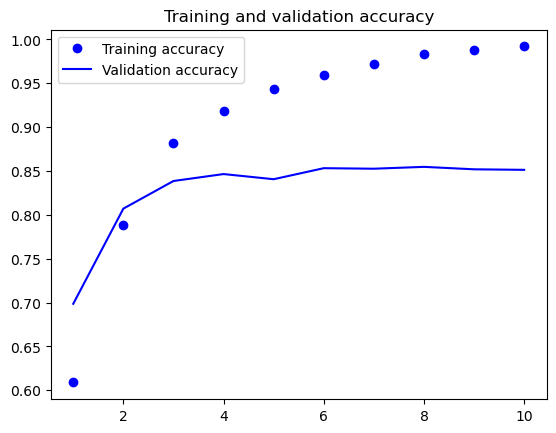

In [59]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [60]:
#optimizer: Adam + trying different learning rate
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=10, batch_size=256, validation_split=0.4)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5324 - loss: 0.6926 - val_accuracy: 0.5400 - val_loss: 0.6909
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5469 - loss: 0.6898 - val_accuracy: 0.5400 - val_loss: 0.6869
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5398 - loss: 0.6847 - val_accuracy: 0.5410 - val_loss: 0.6770
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5696 - loss: 0.6727 - val_accuracy: 0.6509 - val_loss: 0.6525
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6565 - loss: 0.6483 - val_accuracy: 0.7418 - val_loss: 0.5882
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7288 - loss: 0.5710 - val_accuracy: 0.7790 - val_loss: 0.4951
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7813 - loss: 0.4873 - val_accuracy: 0.8080 - val_loss: 0.4386
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8234 - loss: 0.4140 - val_accuracy: 0.8192 - v

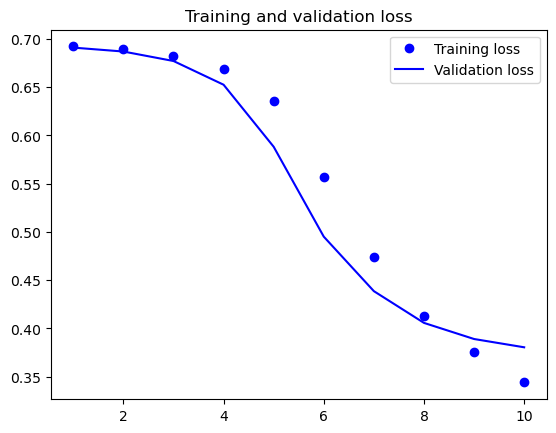

In [61]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

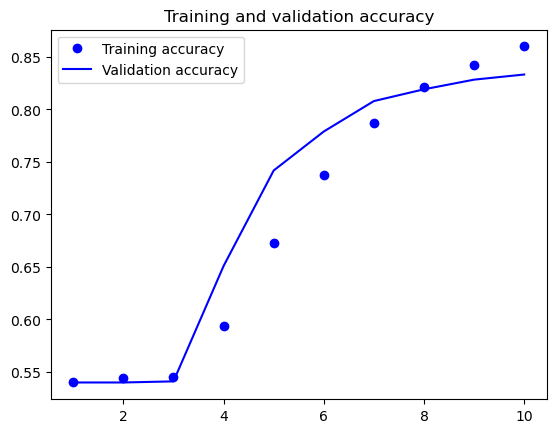

In [62]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [63]:
#optimizer: Adam + trying different learning rate + change for more epochs
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=30, batch_size=256, validation_split=0.4)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5439 - loss: 0.6907 - val_accuracy: 0.5400 - val_loss: 0.6856
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5413 - loss: 0.6849 - val_accuracy: 0.5400 - val_loss: 0.6797
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5444 - loss: 0.6784 - val_accuracy: 0.5404 - val_loss: 0.6727
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5561 - loss: 0.6691 - val_accuracy: 0.5756 - val_loss: 0.6578
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6297 - loss: 0.6468 - val_accuracy: 0.7092 - val_loss: 0.6165
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7192 - loss: 0.5957 - val_accuracy: 0.7687 - val_loss: 0.5302
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7660 - loss: 0.5110 - val_accuracy: 0.8013 - val_loss: 0.4479
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8200 - loss: 0.4179 - val_accuracy: 0.8184 - v

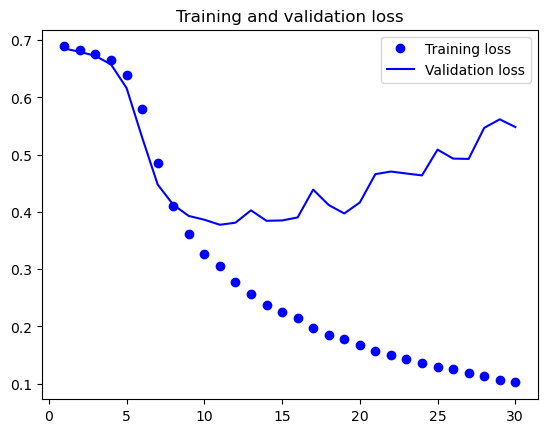

In [64]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

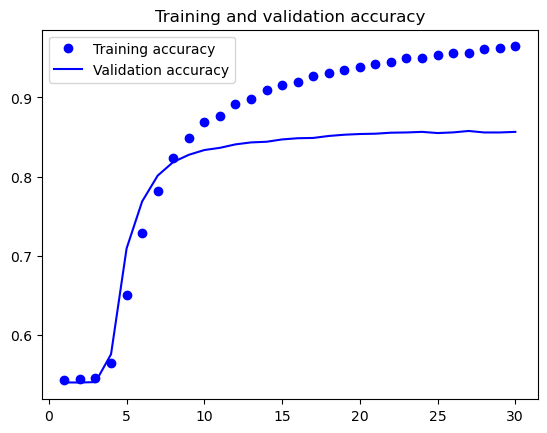

In [65]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [66]:
#add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=20, batch_size=256, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5602 - loss: 0.6812 - val_accuracy: 0.7737 - val_loss: 0.4880
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8158 - loss: 0.4154 - val_accuracy: 0.8329 - val_loss: 0.3772
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9019 - loss: 0.2535 - val_accuracy: 0.8397 - val_loss: 0.3692
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9333 - loss: 0.1889 - val_accuracy: 0.8495 - val_loss: 0.4169
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9560 - loss: 0.1289 - val_accuracy: 0.8515 - val_loss: 0.5334
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9642 - loss: 0.0998 - val_accuracy: 0.8498 - val_loss: 0.6398
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9717 - loss: 0.0844 - val_accuracy: 0.8529 - val_loss: 0.7998


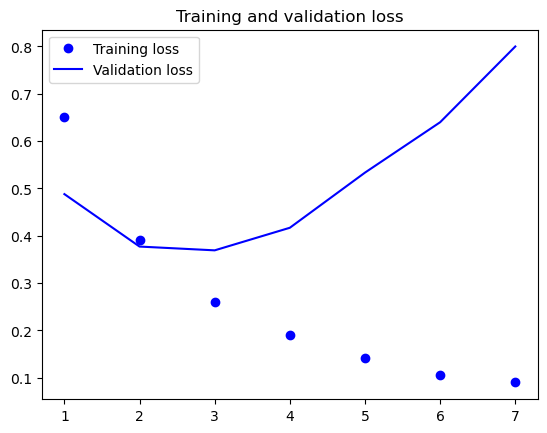

In [67]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

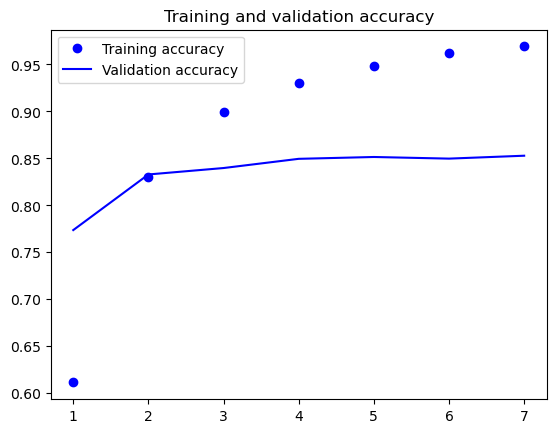

In [68]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [69]:
#add early stopping + rmsprop
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=20, batch_size=256, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5421 - loss: 0.6889 - val_accuracy: 0.5401 - val_loss: 0.6819
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5665 - loss: 0.6800 - val_accuracy: 0.6631 - val_loss: 0.6541
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6681 - loss: 0.6281 - val_accuracy: 0.7583 - val_loss: 0.5234
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7810 - loss: 0.4942 - val_accuracy: 0.8028 - val_loss: 0.4311
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8407 - loss: 0.3822 - val_accuracy: 0.8248 - val_loss: 0.4043
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8786 - loss: 0.3080 - val_accuracy: 0.8339 - val_loss: 0.3886
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9027 - loss: 0.2604 - val_accuracy: 0.8389 - val_loss: 0.3806
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9188 - loss: 0.2247 - val_accuracy: 0.8426 - v

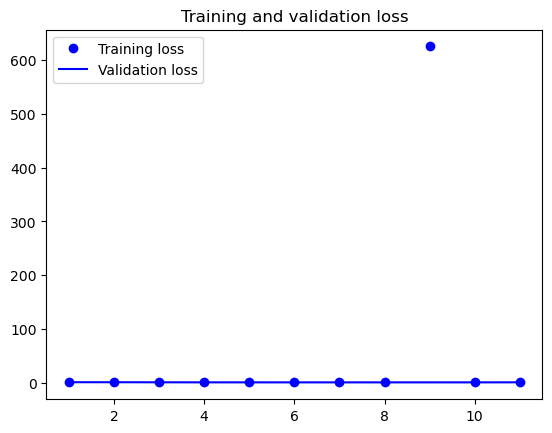

In [70]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

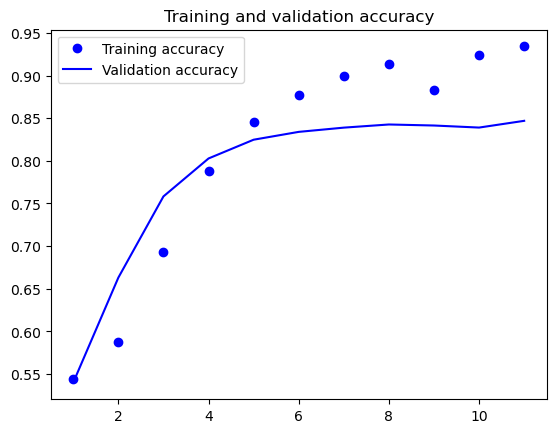

In [71]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [72]:
#add l2 regularizier to LSTM layer
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=20, batch_size=256, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5395 - loss: 1.2276 - val_accuracy: 0.5400 - val_loss: 0.8427
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5456 - loss: 0.7881 - val_accuracy: 0.5435 - val_loss: 0.6950
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5690 - loss: 0.6886 - val_accuracy: 0.6235 - val_loss: 0.6766
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6242 - loss: 0.6682 - val_accuracy: 0.7040 - val_loss: 0.6107
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7123 - loss: 0.5941 - val_accuracy: 0.7473 - val_loss: 0.5400
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7688 - loss: 0.8334 - val_accuracy: 0.7693 - val_loss: 0.5133
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8056 - loss: 0.4778 - val_accuracy: 0.7905 - val_loss: 0.4824
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8400 - loss: 0.4235 - val_accuracy: 0.8033 - v

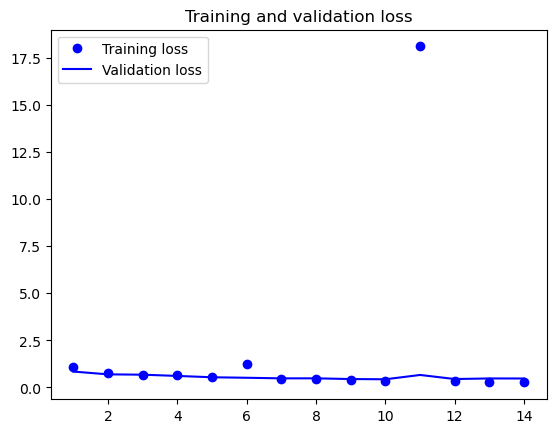

In [73]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

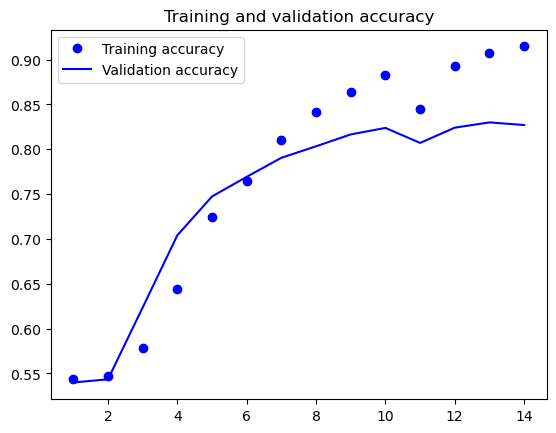

In [74]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [75]:
#l2 regularizier with bigger rate
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=20, batch_size=256, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5253 - loss: 3.3274 - val_accuracy: 0.5400 - val_loss: 1.4333
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5420 - loss: 1.1688 - val_accuracy: 0.5400 - val_loss: 0.7300
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5449 - loss: 0.7060 - val_accuracy: 0.5917 - val_loss: 0.6864
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5704 - loss: 0.6841 - val_accuracy: 0.6022 - val_loss: 0.6781
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6036 - loss: 0.6763 - val_accuracy: 0.6723 - val_loss: 0.6420
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6827 - loss: 0.6272 - val_accuracy: 0.6943 - val_loss: 0.5960
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7454 - loss: 0.5612 - val_accuracy: 0.7608 - val_loss: 0.5405
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7886 - loss: 0.5037 - val_accuracy: 0.7927 - v

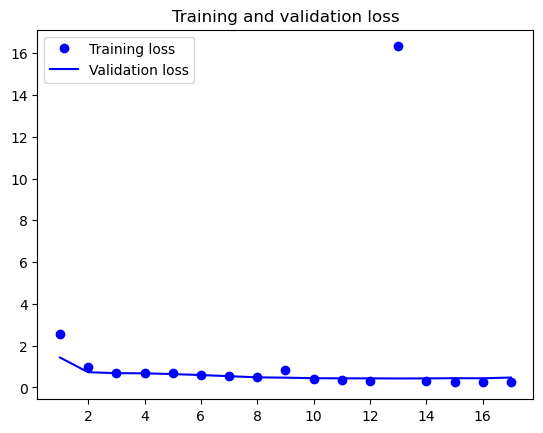

In [76]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

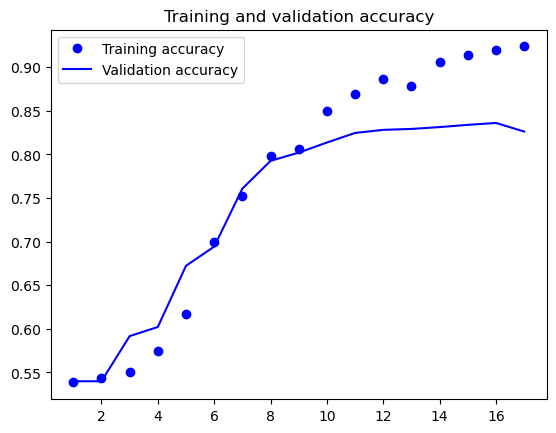

In [77]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [78]:
#final model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_len+1, output_dim=100),
    layers.LSTM(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train_rnn, y_train_rnn,
                             epochs=20, batch_size=256, validation_split=0.4, callbacks=[early_stopping])

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5400 - val_loss: 0.6863
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5427 - loss: 0.6856 - val_accuracy: 0.5802 - val_loss: 0.6755
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6130 - loss: 0.6648 - val_accuracy: 0.7147 - val_loss: 0.5789
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7103 - loss: 0.8475 - val_accuracy: 0.7651 - val_loss: 0.5005
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7834 - loss: 0.4767 - val_accuracy: 0.7964 - val_loss: 0.4674
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8381 - loss: 0.3832 - val_accuracy: 0.8204 - val_loss: 0.4039
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8792 - loss: 0.3093 - val_accuracy: 0.8318 - val_loss: 0.3893
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8999 - loss: 0.2650 - val_accuracy: 0.8366 - v

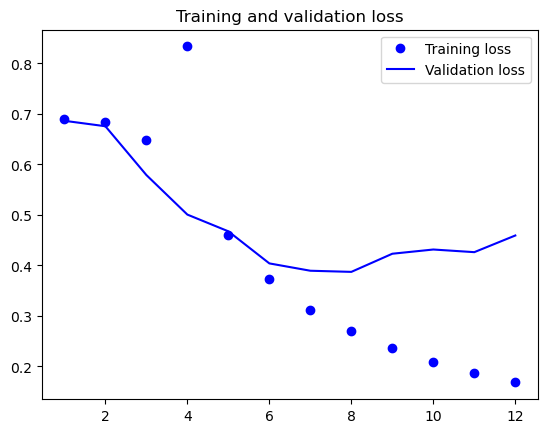

In [79]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

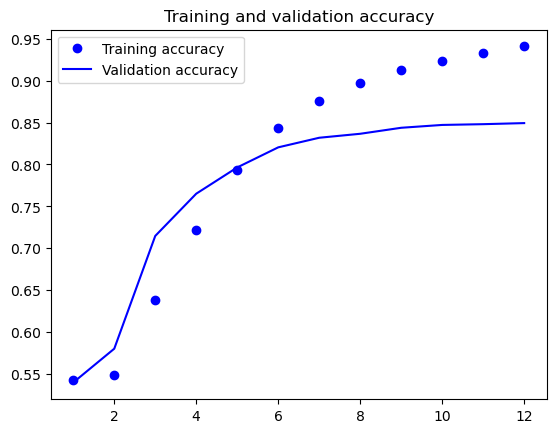

In [80]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [81]:
y_pred_rnn = model.predict(X_test_rnn)

692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [82]:
y_pred_rnn

array([[0.893951  ],
       [0.60930693],
       [0.696807  ],
       ...,
       [0.8189767 ],
       [0.81357014],
       [0.9162598 ]], dtype=float32)

In [83]:
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

In [84]:
f1 = f1_score(y_test_rnn, y_pred_rnn, average='macro')
f1

0.8268447878312883

In [85]:
conf = confusion_matrix(y_test_rnn, y_pred_rnn)
conf

array([[10097,  1871],
       [ 1934,  8230]])

In [88]:
model.save('../sarcasm_detector.keras')